# Tutorial: Searching a TraP dataset for transient and variable sources
## Author: Antonia Rowlinson

This Jupyter Notebook is a demo for demonstrating the current best practice for searching for transients and variable sources in the output from the LOFAR Transients Pipeline, TraP (Swinbank et al. 2015). TraP is a publicly available pipeline with the following resources:
- [Code](https://github.com/transientskp/tkp)
- [Documentation](https://docs.transientskp.org)
- [Publication](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)

Example recent transient surveys using TraP outputs:
- Identifying radio transient and variable sources with statistical methods [Valdata et al. (in prep)]()
- A new method for short-duration transient detection in radio images: searching for transient sources in MeerKAT data of NGC 5068 [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract)
- Commensal transient searches in eight short gamma-ray burst fields [Chastain et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.1888C/abstract)
- LOFAR observations of gravitational wave merger events: O3 results and O4 strategy [Gourdji et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.4748G/abstract)
- Search and identification of transient and variable radio sources using MeerKAT observations: a case study on the MAXI J1820+070 field [Rowlinson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.517.2894R/abstract)
- 21 new long-term variables in the GX 339-4 field: two years of MeerKAT monitoring [Driessen et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.5037D/abstract)
- Identifying transient and variable sources in radio images [Rowlinson et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract)


The methods presented in this Jupyter Notebook are the culmination of years working with the TraP outputs. 

Please cite the appropriate papers from above when using these tools.

**CAVEATS:** 
- These methods may not catch everything interesting/unusual in the TraP databases! We are still refining search techniques to find out more.
- Get to know your data to confirm these 'standard' settings work for you! I recommend studying a small percentage of large datasets to get a feel for what type of filtering and processing strategy works best for you.
- This Jupyter Notebook will be slow for very large datasets. Split it into smaller processes or standalone scripts.

### Quality Control: Pre-TraP Assessment

Quality control of your data is essential for ensuring that you minimise the number of false positive detections. We have found that the simplest and most optimal method for datasets checked to date is implementing an rms noise clip on your images. This clipping can be conducted in TraP, but you need to determine what the optimal settings are for your data. n.b. there is an automated version in TraP, but it is currently very slow and I recommend you do not use it.

The code below will load all images in the path and calculate the rms noise in the inner part of your image. This is the identical method to that used in TraP to determine the rms noise in the images. The documentation for this part of TraP is [here](https://tkp.readthedocs.io/en/release4.0/userref/structure/stages/quality.html). The TraP also conducts a check on the restoring beam shape and for nearby bright sources.

This code is based upon the PreTraPimageQC code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

**CAVEATS** 
- This part assumes you only have 1 observing frequency. See the full code for how to handle multiple frequency datasets.
- The version below fits the rms noise in linear space whereas in the full code we used log space. Further investigation required to determine if linear space is sufficient.
- For very large datasets, this gets very slow. I recommend using a representative subset, e.g. 10%, to characterise what a good image should look like and then apply the thresholds to your full dataset in TraP. Conducting a random sample of your images is now implemented in this code.

In [8]:
import sys
import os
import astropy.io.fits as pyfits
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt 
import random
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord


In [9]:
import getRMS  
# This is a script that is in the github repository associated with this code. 
# It will calculate a sigma clipped rms in the inner region of the images being processed.
# The clipping factor and relative size of the image to be considered can be input as parameters.

In [10]:
randomPercentage = 0.005
# This is the percentage of the data you want to use for the quality control steps

In [11]:
sigmaClip = 3 # This is the sigma clip used to remove sources from the rms calculation. 
# Usually 3 is used in TraP (see rms_est_sigma in the job_config)

In [12]:
f = 8 # This is the fraction of the image that will be used for the rms calculation.
# Usually 8 is used in TraP.

In [13]:
sigmaRej = 3 # This is the rejection sigma for bad images.
# If the image is deviant from the mean by more than this value (positive or negative) the image is rejected.

In [14]:
path_to_images = '/archive/TraP_test_data/ELAIS-N1/L*/'

Read all the images and measure the rms noise in the central region. Store as a Pandas dataframe.

In [15]:
imageList = glob.glob(path_to_images+'*.fits')
numImages = len(imageList)
randomImages = random.sample(imageList,int(randomPercentage*numImages))
print(len(randomImages))

476


In [16]:
imageData=[]
for filename in randomImages:
    data = getRMS.read_data(pyfits.open(filename)[0],filename, plane=None)
    imageData.append([filename, getRMS.rms_with_clipped_subregion(data, sigmaClip, f)*1000.])

imageData = pd.DataFrame(imageData, columns=['filename','rms'])
imageData

KeyboardInterrupt: 

Fit a histogram to the rms noise values. n.b. sometimes you have to tweak the number of bins (here and in the boxes 19 & 20) to get the Gaussian fitting working sufficiently well for your data.

In [ ]:
plt.hist(imageData.rms,bins=50,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

Drop images that have NaN as their rms value and those with extreme rms values.

In [ ]:
imageData = imageData.dropna()
mean=np.mean(imageData.rms)
stdev = np.std(imageData.rms)
imageData = imageData[imageData.rms < mean+5*stdev]

plt.hist(imageData.rms,bins=50,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

In [ ]:
# functions to fit a Gaussian distribution to data

def res(p, y, x):
# calculate residuals between data and Gaussian model
  m1, sd1, a = p
  y_fit = a*norm2(x, m1, sd1)
  err = y - y_fit
  return err

def guess_p(x):
# estimate the mean and rms as initial inputs to the Gaussian fitting
    median = np.median(x)
    temp=[n*n-(median*median) for n in x]
    rms = math.sqrt((abs(sum(temp))/len(x)))
    return [median, rms, math.sqrt(len(x))]

def norm2(x, mean, sd):
# creates a normal distribution in a simple array for plotting
    normdist = []
    for i in range(len(x)):
        normdist += [1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2))]
    return np.array(normdist)

In [ ]:
from scipy.optimize import leastsq
import math

# Obtain the data in a binned histogram for fitting
hist_rms=np.histogram(imageData.rms,bins=500)
range_x=[hist_rms[1][n]+(hist_rms[1][n+1]-hist_rms[1][n])/2. for n in range(len(hist_rms[1])-1)]

# Guess the mean and standard deviation based upon the median value
p = guess_p(imageData.rms)

# Calculate the best fitting Gaussian distribution
plsq = leastsq(res, p, args = (hist_rms[0], range_x)) # fit Gaussian to data
fit2 = plsq[0][2]*norm2(range_x, plsq[0][0], plsq[0][1]) # create Gaussian distribution for plotting on graph

In [ ]:
# Create a plot of the results

plt.plot(range_x,fit2, 'r-', linewidth=3)
plt.hist(imageData.rms,bins=500,histtype='stepfilled')

sigcut=plsq[0][0]+plsq[0][1]*sigmaRej # max threshold defined as (mean + RMS * sigma)
sigcut2=plsq[0][0]-plsq[0][1]*sigmaRej # min threshold defined as (mean - RMS * sigma)
plt.axvline(x=sigcut, linewidth=2, color='k',linestyle='--')
plt.axvline(x=sigcut2, linewidth=2, color='k', linestyle='--')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.savefig('rms_plot.png')
plt.show()

In [ ]:
# Thresholds for TraP job parameters file (job_params.cfg):
print('rms_est_max = '+str(sigcut/1e3))
print('rms_est_min = '+str(sigcut2/1e3))

### Choosing an appropriate systematic position offset

The position uncertainties output by the transients pipeline are only measurement errors and do not account for systematic position uncertainties caused by e.g. the ionosphere.

Setting this systematic position offset to be too high will lead to bad source associations and not including it means that bright sources may not be correctly associated.

Here we use a random sample of images in the dataset to quantify the typical position offset in snapshot images versus the source position in a deep image of the field. We use a simple source association procedure from astropy.


In [17]:
deepImage = '/scratch/ideruiter/deep_fields_individual_epochs/L686976_image_full_ampphase_di_m.NS.app.restored.fits'
detectThresh = 6.
detectThreshDeep = 20.
radius = 900 # pixels
radiusDeep = 3600
grid = 50 # pixels
deblend = 0 # 0 = turned off
forceBeam = True
maxSep = 20  # arcsec
minSNR = 20 # use a large value to ensure that you are only using the brightest sources to estimate the uncertainty

Run the source finder, PySE, on all the images in the random sample of images to measure the positions of the sources and their uncertainties.

In [ ]:
for image in randomImages:
    img = image.split('.')[0]+'.csv'
    img = img.split('/')[-1]
    if os.path.isfile(img):
        print(img)
    else:
        if forceBeam:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+' --force-beam --csv '+image)
        else:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds --csv '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+image)

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L230779/ELIAS_L230779-t1655-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L230779/ELIAS_L230779-t1655-image-pb.fits **

RA: -115.168+-0.0035408, dec: 54.8048+-0.000744577
Error radius (arcsec): 7.824186299587139
Semi-major axis (arcsec): 63.5678+-6.42191
Semi-minor axis (arcsec): 10.8074+-1.09181
Position angle: 109.558+-1.43346
Flux: 0.352385+-0.0616601
Peak: 0.348788+-0.0352362

RA: -115.248+-0.000834432, dec: 54.4935+-0.000176778
Error radius (arcsec): 1.8579968268821887
Semi-major axis (arcsec): 63.5693+-1.52499
Semi-minor axis (arcsec): 10.8073+-0.259262
Position angle: 109.487+-0.340391
Flux: 2.14916+-0.0892994
Peak: 2.14792+-0.0515274

RA: -115.362+-0.00481618, dec: 54.5289+-0.00101913
Error radius (arcsec): 10.713726843534827
Semi-major axis (arcsec): 63.5675+-8.79354
Semi-minor axis (arcsec): 10.8073+-1.49502
Position angle: 109.394+-1.96285
Flux: 0.

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L686934/ELIAS_L686934-t1444-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L686934/ELIAS_L686934-t1444-image-pb.fits **

RA: -115.163+-0.00272938, dec: 54.8053+-0.00125223
Error radius (arcsec): 7.241776184240214
Semi-major axis (arcsec): 63.3609+-5.93475
Semi-minor axis (arcsec): 11.3477+-1.06289
Position angle: 129.782+-1.40449
Flux: 0.645392+-0.104704
Peak: 0.63973+-0.0599208

RA: -115.246+-0.000483477, dec: 54.4928+-0.000223532
Error radius (arcsec): 1.2927266657687941
Semi-major axis (arcsec): 63.3645+-1.05941
Semi-minor axis (arcsec): 11.3473+-0.189718
Position angle: 129.709+-0.2507
Flux: 3.14152+-0.0909741
Peak: 3.14064+-0.0525093

RA: -115.364+-0.00320858, dec: 54.5298+-0.00148208
Error radius (arcsec): 8.570785677649006
Semi-major axis (arcsec): 63.3627+-7.02389
Semi-minor axis (arcsec): 11.3473+-1.25787
Position angle: 129.613+-1.66219
Flux: 0.54230

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L686948/ELIAS_L686948-t1612-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L686948/ELIAS_L686948-t1612-image-pb.fits **

RA: -115.168+-0.0025532, dec: 54.8069+-0.00101579
Error radius (arcsec): 6.440041776626938
Semi-major axis (arcsec): 64.0428+-5.28019
Semi-minor axis (arcsec): 11.2953+-0.931275
Position angle: 125.604+-1.21629
Flux: 0.301706+-0.0430848
Peak: 0.299655+-0.0247059

RA: -115.248+-0.000743576, dec: 54.4943+-0.000298113
Error radius (arcsec): 1.8900599324813765
Semi-major axis (arcsec): 64.0461+-1.54966
Semi-minor axis (arcsec): 11.2949+-0.273292
Position angle: 125.532+-0.356943
Flux: 1.507+-0.0631562
Peak: 1.50611+-0.0364419

RA: -115.366+-0.00444737, dec: 54.53+-0.00178137
Error radius (arcsec): 11.293800196953459
Semi-major axis (arcsec): 64.0443+-9.25978
Semi-minor axis (arcsec): 11.2949+-1.63307
Position angle: 125.437+-2.13293
Flux: 0.2778

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L347404/ELIAS_L347404-t1010-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L347404/ELIAS_L347404-t1010-image-pb.fits **

RA: -115.168+-0.00324348, dec: 54.805+-0.00119867
Error radius (arcsec): 7.99828705673807
Semi-major axis (arcsec): 51.9048+-6.52527
Semi-minor axis (arcsec): 10.5623+-1.32785
Position angle: 123.202+-2.16282
Flux: 0.240113+-0.0522838
Peak: 0.236318+-0.029709

RA: -115.249+-0.000799065, dec: 54.4907+-0.00029759
Error radius (arcsec): 1.9857786283623806
Semi-major axis (arcsec): 51.9073+-1.62006
Semi-minor axis (arcsec): 10.562+-0.329647
Position angle: 123.13+-0.536949
Flux: 1.12596+-0.060868
Peak: 1.12487+-0.0351079

RA: -115.358+-0.00364337, dec: 54.5255+-0.00135562
Error radius (arcsec): 9.045854491643501
Semi-major axis (arcsec): 51.9059+-7.3799
Semi-minor axis (arcsec): 10.562+-1.50169
Position angle: 123.042+-2.44604
Flux: 0.276332+-0.

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L816272/ELIAS_L816272-t0145-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L816272/ELIAS_L816272-t0145-image-pb.fits **

RA: -115.173+-0.00464528, dec: 54.8017+-0.00174181
Error radius (arcsec): 11.504754713560459
Semi-major axis (arcsec): 61.9774+-9.38352
Semi-minor axis (arcsec): 12.6944+-1.92196
Position angle: 123.601+-2.62322
Flux: 0.240337+-0.0630252
Peak: 0.234828+-0.0355535

RA: -115.247+-0.000789899, dec: 54.4913+-0.000298449
Error radius (arcsec): 1.9713305069300489
Semi-major axis (arcsec): 61.9804+-1.60786
Semi-minor axis (arcsec): 12.694+-0.329299
Position angle: 123.535+-0.449464
Flux: 1.35426+-0.0608493
Peak: 1.35335+-0.0351077

RA: -115.37+-0.00440885, dec: 54.5306+-0.00166408
Error radius (arcsec): 10.99157101658915
Semi-major axis (arcsec): 61.9786+-8.96494
Semi-minor axis (arcsec): 12.694+-1.83613
Position angle: 123.435+-2.50616
Flux: 0.273

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L816326/ELIAS_L816326-t0237-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L816326/ELIAS_L816326-t0237-image-pb.fits **

RA: -115.138+-0.00442756, dec: 54.798+-0.00116289
Error radius (arcsec): 10.101941533402414
Semi-major axis (arcsec): 56.1726+-8.20085
Semi-minor axis (arcsec): 12.7795+-1.86572
Position angle: 113.323+-2.83885
Flux: 0.192709+-0.04873
Peak: 0.188601+-0.0275346

RA: -115.161+-0.00307844, dec: 54.8047+-0.000808375
Error radius (arcsec): 7.022486240791469
Semi-major axis (arcsec): 56.1723+-5.70092
Semi-minor axis (arcsec): 12.7795+-1.29699
Position angle: 113.304+-1.97347
Flux: 0.273262+-0.0480355
Peak: 0.270447+-0.0274476

RA: -115.185+-0.00415649, dec: 54.812+-0.00109122
Error radius (arcsec): 9.479832950919524
Semi-major axis (arcsec): 56.172+-7.69581
Semi-minor axis (arcsec): 12.7795+-1.75084
Position angle: 113.285+-2.66405
Flux: 0.200444+

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L347030/ELIAS_L347030-t0597-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L347030/ELIAS_L347030-t0597-image-pb.fits **

RA: -115.166+-0.00185279, dec: 54.8053+-0.001075
Error radius (arcsec): 5.457467825264037
Semi-major axis (arcsec): 46.2357+-3.82958
Semi-minor axis (arcsec): 29.5169+-2.4448
Position angle: 46.2356+-7.23076
Flux: 0.263131+-0.0377491
Peak: 0.261326+-0.0216449

RA: -115.248+-0.000452983, dec: 54.4937+-0.000264859
Error radius (arcsec): 1.3446083079340907
Semi-major axis (arcsec): 46.2336+-0.943427
Semi-minor axis (arcsec): 29.5187+-0.60235
Position angle: 46.1615+-1.7814
Flux: 1.61339+-0.0570229
Peak: 1.61271+-0.0329085

RA: -115.364+-0.00324456, dec: 54.5285+-0.00189551
Error radius (arcsec): 9.622292561881942
Semi-major axis (arcsec): 46.2335+-6.7515
Semi-minor axis (arcsec): 29.518+-4.31054
Position angle: 46.0683+-12.7484
Flux: 0.236985+-

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L816344/ELIAS_L816344-t0944-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L816344/ELIAS_L816344-t0944-image-pb.fits **

RA: -115.14+-0.00194367, dec: 54.8062+-0.00326576
Error radius (arcsec): 12.435050067478391
Semi-major axis (arcsec): 64.3117+-10.2022
Semi-minor axis (arcsec): 11.0918+-1.75957
Position angle: 165.266+-2.28455
Flux: 0.13576+-0.0373025
Peak: 0.132344+-0.0209946

RA: -115.166+-0.00123898, dec: 54.8066+-0.00208193
Error radius (arcsec): 7.9271860013983435
Semi-major axis (arcsec): 64.3117+-6.50378
Semi-minor axis (arcsec): 11.0918+-1.1217
Position angle: 165.244+-1.45637
Flux: 0.212574+-0.0372345
Peak: 0.2104+-0.0212775

RA: -115.192+-0.00177806, dec: 54.8034+-0.0029883
Error radius (arcsec): 11.378097885840432
Semi-major axis (arcsec): 64.3117+-9.33505
Semi-minor axis (arcsec): 11.0917+-1.61
Position angle: 165.223+-2.09037
Flux: 0.147572+-0.

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L816308/ELIAS_L816308-t1034-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L816308/ELIAS_L816308-t1034-image-pb.fits **

RA: -115.14+-0.00263533, dec: 54.8087+-0.00306994
Error radius (arcsec): 12.336177273096883
Semi-major axis (arcsec): 65.2246+-10.1308
Semi-minor axis (arcsec): 10.8689+-1.68818
Position angle: 156.721+-2.15691
Flux: 0.152481+-0.0410214
Peak: 0.148802+-0.0231123

RA: -115.168+-0.00155958, dec: 54.8079+-0.00181691
Error radius (arcsec): 7.300891138749893
Semi-major axis (arcsec): 65.2245+-5.99571
Semi-minor axis (arcsec): 10.8688+-0.999108
Position angle: 156.699+-1.27652
Flux: 0.263981+-0.0420303
Peak: 0.26175+-0.0240612

RA: -115.19+-0.00276064, dec: 54.8004+-0.00321687
Error radius (arcsec): 12.926105405874221
Semi-major axis (arcsec): 65.2246+-10.6153
Semi-minor axis (arcsec): 10.8688+-1.76889
Position angle: 156.681+-2.26006
Flux: 0.1556

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L686934/ELIAS_L686934-t0852-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L686934/ELIAS_L686934-t0852-image-pb.fits **

RA: -115.164+-0.000775055, dec: 54.8047+-0.00126313
Error radius (arcsec): 4.825508092856176
Semi-major axis (arcsec): 63.2949+-3.96427
Semi-minor axis (arcsec): 10.4067+-0.651788
Position angle: 164.368+-0.857458
Flux: 0.655791+-0.071141
Peak: 0.653218+-0.0409122

RA: -115.246+-0.000161703, dec: 54.4933+-0.000265651
Error radius (arcsec): 1.014813844858317
Semi-major axis (arcsec): 63.2987+-0.833694
Semi-minor axis (arcsec): 10.4063+-0.137059
Position angle: 164.295+-0.180314
Flux: 3.93894+-0.089857
Peak: 3.93826+-0.05187

RA: -115.165+-0.0018078, dec: 55.5987+-0.00288804
Error radius (arcsec): 11.033717691849448
Semi-major axis (arcsec): 63.2927+-9.06327
Semi-minor axis (arcsec): 10.4075+-1.49031
Position angle: 164.384+-1.96042
Flux: 0.34

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L686990/ELIAS_L686990-t0212-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L686990/ELIAS_L686990-t0212-image-pb.fits **

RA: -115.143+-0.00428771, dec: 54.7996+-0.0010907
Error radius (arcsec): 9.730244318285106
Semi-major axis (arcsec): 53.7641+-7.88863
Semi-minor axis (arcsec): 12.5571+-1.84246
Position angle: 112.294+-2.93769
Flux: 0.18272+-0.0464362
Peak: 0.178787+-0.0262328

RA: -115.167+-0.00314057, dec: 54.8042+-0.000798764
Error radius (arcsec): 7.126073808412951
Semi-major axis (arcsec): 53.7638+-5.77734
Semi-minor axis (arcsec): 12.557+-1.34935
Position angle: 112.275+-2.15147
Flux: 0.247206+-0.0460106
Peak: 0.244352+-0.0262575

RA: -115.246+-0.000523923, dec: 54.4925+-0.000134262
Error radius (arcsec): 1.197937442636761
Semi-major axis (arcsec): 53.7653+-0.971201
Semi-minor axis (arcsec): 12.5569+-0.226825
Position angle: 112.204+-0.361663
Flux: 1.3

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing /archive/TraP_test_data/ELAIS-N1/L231211/ELIAS_L231211-t0189-image-pb.fits (file 1 of 1).
Thresholding with det = 6.000000 sigma, analysis = 3.000000 sigma
** /archive/TraP_test_data/ELAIS-N1/L231211/ELIAS_L231211-t0189-image-pb.fits **

RA: -115.162+-0.00325343, dec: 54.805+-0.000692665
Error radius (arcsec): 7.199714229810344
Semi-major axis (arcsec): 50.019+-5.82337
Semi-minor axis (arcsec): 12.2017+-1.42056
Position angle: 107.189+-2.44746
Flux: 6.33385+-1.27723
Peak: 6.248+-0.727411

RA: -115.246+-0.000488888, dec: 54.4933+-0.000104864
Error radius (arcsec): 1.0901915890872709
Semi-major axis (arcsec): 50.0199+-0.881776
Semi-minor axis (arcsec): 12.2017+-0.215098
Position angle: 107.114+-0.370588
Flux: 34.8069+-1.06278
Peak: 34.7961+-0.613404

RA: -115.246+-0.00437846, dec: 54.5149+-0.000938659
Error radius (arcsec): 9.75854661999612
Semi-major axis (arcsec): 50.0197+-7.89297
Semi-minor axis (arcsec): 12.2017+-1.92539
Position angle: 107.115+-3.31722
Flux: 3.99577+-1.09

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Run PySE on the deep image to get the main source catalogue. Use 20 sigma detection threshold so only brighter sources. Otherwise the same PySE settings.

In [ ]:
img = deepImage.rstrip('.fits')+'.csv'
img = img.split('/')[-1]
if os.path.isfile(img):
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
else:       
    if forceBeam:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+' --force-beam --csv '+deepImage)
    else:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds --csv '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+deepImage)
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
#print(runcat.columns.tolist())
runcat['SkyCoords'] = runcat.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
#print(runcat)
rct = coord.SkyCoord(runcat.ra, runcat.dec, unit=(u.deg, u.deg), frame='fk5')

Loop through all the images to determine the offset from the deep image position. Use astropy source association

In [ ]:
if os.path.exists('seps.csv'):
    AllSeps = pd.read_csv('seps.csv')
else:
    AllSeps = pd.DataFrame(columns = ['img','ra_err','dec_err','sep','snr'])
    for image in images:
        img = image.split('.')[0]+'.csv'
        img = img.split('/')[-1]
        sources = pd.read_csv(img, delimiter=', ', engine='python')
        sources['SkyCoords'] = sources.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
        srcs = coord.SkyCoord(sources.ra, sources.dec, unit=(u.deg, u.deg), frame='fk5')
        idx, d2d, d3d = srcs.match_to_catalog_sky(rct)
        seps = np.array(d2d.arcsecond)     
        sources['sep']=seps
        sources['img']=img
        sources = sources.filter(['img','ra_err','dec_err','sep','snr'])
        AllSeps = pd.concat([AllSeps, sources])
    
    AllSeps.to_csv('seps.csv')

Conduct selections on the data to reject bad associations (using maxSep) and to focus on only the high SNR sources

In [ ]:
AllSeps = AllSeps[AllSeps.sep < maxSep]
AllSeps = AllSeps[AllSeps.snr > minSNR]

The offsets being measured should be a combination of the fitting error and the systematic error. These are normally added in quadrature. i.e. offset = sqrt ( ra_error^2 + dec_error^2 + systematic^2) --> offset^2 / (ra_error^2 + dec_error^2 ) = systematic^2
We use the median values so as not to be biased towards larger offsets.


In [ ]:
systematic = np.median(AllSeps.sep)**2. / (np.median(3600*AllSeps.ra_err)**2. + np.median(3600*AllSeps.dec_err)**2.)
print(systematic**0.5)

### Running the TraP

The next step in the process is running the TraP on your data. You need to set up the TraP according to the instructions and initiate a job.

The images_to_process.py file will look like with the "path_to_images" used above:

The job_params.cfg file will look like this, with the rms limits from above:

**Some advice for job_params.cfg**

Generally, the default parameters generally work well but you may want to take the following into consideration.

- I recommend preventing the automatic rms thresholding by setting *rms_est_history* to a larger number than the number of images you wish to process. While the current implementation does work, it is very slow so dramatically impacts performance.

- *detection_threshold = 8* you may want to edit this such that you can control the number of false positive detections in your images. For further details, see e.g. Section 4.1 of [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract).

- *extraction_radius = 250* choose an appropriate source extraction radius in pixels to cover the optimal search area in your images. I recommend that you do not go too close to the image edge.
  
- *expiration = 10* This is the number of forced fits that TraP conducts after the last detection. This number is useful for controlling the number of sources that TraP is monitoring - otherwise you could reach a scenario where every pixel is being monitored in the image. It also helps speed up the TraP.

- *ns_sys_err = 10* and *ew_sys_err = 10* Replace this with the systematic position uncertainty from your dataset

When you run TraP, make a note of the dataset id for your TraP run and insert it here. Also give the name of the database you are using:

(It's in the screen output, look for this line `tkp.steps.persistence: created dataset 101 (TRAP dataset)`)

In [103]:
dataset_id = 34
database = 'antoniar'

You now need to specify your postgresql database, username, password etc. All of this information is in the file pipeline.cfg that you used to setup the TraP. Input this into the file dblogin.py, which looks like:

The database settings are then obtained by simply importing the dblogin.py file.

In [104]:
from dblogin import *

We now open a connection to the database using SQLAlchemy.

In [105]:
import tkp.db
from sqlalchemy import *

db = tkp.db.Database(engine=engine, host=host, port=port, user=user, password=password, database=database)
db.connect()
session = db.Session()

Not configuring pre-configured database


Once this is complete, you can now access the various datasets and associated tables in the following. I recommend using [SQLAlchemy](https://www.sqlalchemy.org), but it is possible to also use SQL commands. In the following, we then consider transients and variables separately.

### Variability Searches


Much of the work in this section is based upon the methods and codes presented in [Rowlinson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract) and [Valdata et al. (in prep)]()

TraP measures two variability parameters (see [Swinbank et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)):
 - **the reduced weighted &chi;^2 (&eta;)** : This is from a fit to the light curve assuming that the flux density of your source is constant. The larger this value, the less well it fits to a horizontal line and thus the more variable the source is.
 - **the coefficient of variation (V)** : This measures the magnitude of the flux density variation in the light curve. The larger this value, the larger the variation in the flux density measurements and thus the more variable the source is.

For reference, TraP measures this value for every single time step in the light curve. Typically (and in the following code), we just use the value associated with the last data point in the light curve when assessing the variability of sources.

Much of the following code is based on the FilterVariables.py code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

First, let's get the variability parameters for all the sources in the dataset. We do this by querying the Varmetric and Runningcatalog tables in the TraP database. So first, import the tools required for those tables and then obtain the data from the database.

In [106]:
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog

VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()

n.b. the original code checks for duplicate sources in this table. This was because the old version of TraP sometimes misassociated sources and made a duplicate source. Further testing is ongoing to determine if this is also the case for the latest version as the code has been improved. We do not check for duplicates in this notebook.

Next, we pull out the specific columns we require and convert them into a Pandas dataframe.

In [107]:
# Set up data for plotting
plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Varmetric.eta_int, VarParams[i].Varmetric.v_int, VarParams[i].Varmetric.lightcurve_max, VarParams[i].Varmetric.lightcurve_median, (VarParams[i].Varmetric.band.freq_central/1e6), VarParams[i].Runningcatalog.datapoints, VarParams[i].Varmetric.newsource] for i in range(len(VarParams))]
plotdata = pd.DataFrame(data=plotdata,columns=['runcat','eta','V','maxFlx','avgFlx','freq','dpts','newSrc'])
plotdata = plotdata.fillna('N')

For simplicity, we ignore all sources that are identified as new sources. These are sources that were not identified in the first image and may be transients. The candidate transients are filtered using a different strategy (see section on Transient Searches).

We also reject any remaining sources that have 0 for one of their variability parameters.

#### Getting the positions of the sources

In [108]:
plotdata = plotdata.loc[(plotdata['eta'] > 0) & (plotdata['V'] > 0) & (plotdata['newSrc']=='N')] # & (plotdata['dpts'] > 2)]# & (plotdata['newSrc']=='N')]

In [109]:
from tkp.db.model import Extractedsource
from tkp.db.model import Assocxtrsource
from tkp.db.model import Image

In [110]:
images= session.query(Image).filter(Image.dataset_id == dataset_id).all()
images = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

We now extract the position of the sources from the database.

In [111]:
runcatData = session.query(Runningcatalog).filter(Runningcatalog.dataset_id == dataset_id).all()

positions = [[runcatData[i].id,runcatData[i].wm_ra,runcatData[i].avg_ra_err,runcatData[i].wm_decl,runcatData[i].avg_decl_err] for i in range(len(runcatData))]
positions = pd.DataFrame(data=positions,columns=['runcat','ra','ra_err','dec','dec_err'])

Combine these positions with the variable candidates.

In [112]:
plotdata = pd.merge(plotdata,positions,how='inner', on='runcat')
plotdata

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err
0,44266,12.230086,0.105074,1.696256,1.375493,144.62738,1797,N,-115.247390,0.004807,54.493458,0.002787
1,44273,0.570471,0.074160,0.434200,0.365668,144.62738,1797,N,-116.619545,0.005054,54.455086,0.002890
2,44274,1.065731,0.052791,1.360462,1.185993,144.62738,887,N,-116.853407,0.005121,56.474023,0.002792
3,44277,0.522138,0.084046,0.416114,0.332750,144.62738,1797,N,-117.488279,0.005315,55.878484,0.002924
4,44282,4.661572,0.072426,1.286644,1.109243,144.62738,1797,N,-118.499835,0.004867,54.901612,0.002792
...,...,...,...,...,...,...,...,...,...,...,...,...
238,45192,34.296517,0.088380,2.854280,2.394660,144.62738,1794,N,-116.948503,0.004898,55.384559,0.002781
239,45196,1.015155,0.175888,0.328370,0.223683,144.62738,1609,N,-115.163747,0.005621,54.804800,0.003137
240,45198,1.020700,0.176357,0.328370,0.223683,144.62738,1613,N,-115.163717,0.005625,54.804820,0.003137
241,45199,1.025227,0.176804,0.328370,0.223683,144.62738,1615,N,-115.163695,0.005628,54.804836,0.003137


#### Filtering out sidelobes

Sometimes sidelobes can be detected in the first image as a unique runcat source. We do not want these sources to be flagged as variable so we remove them from the list of sources to be considered.

To see a full analysis of how to handle sidelobes, refer to de Ruiter et al. (2021) and de Ruiter et al. (2023).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

CAVEAT: This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [113]:
import astropy.units as u
from astropy.coordinates import SkyCoord

FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# identify the brightest sources
runcat_bright = plotdata.loc[plotdata.avgFlx > BrightSrcFlx]
SrcPos = SkyCoord(ra=(plotdata.ra.values)*u.degree,dec=(plotdata.dec.values)*u.degree)
brightSrcsPos = SkyCoord(ra=(runcat_bright.ra.values)*u.degree,dec=(runcat_bright.dec.values)*u.degree)

idx1, d2d, d3d = SrcPos.match_to_catalog_sky(brightSrcsPos)
plotdata['nearestBrtSrc'] = d2d.deg
plotdata = plotdata.loc[(plotdata.nearestBrtSrc > FilterRadius/60.) | (plotdata.nearestBrtSrc == 0)]
plotdata

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err,nearestBrtSrc
0,44266,12.230086,0.105074,1.696256,1.375493,144.62738,1797,N,-115.247390,0.004807,54.493458,0.002787,0.000000
1,44273,0.570471,0.074160,0.434200,0.365668,144.62738,1797,N,-116.619545,0.005054,54.455086,0.002890,0.668445
2,44274,1.065731,0.052791,1.360462,1.185993,144.62738,887,N,-116.853407,0.005121,56.474023,0.002792,0.000000
3,44277,0.522138,0.084046,0.416114,0.332750,144.62738,1797,N,-117.488279,0.005315,55.878484,0.002924,0.580345
4,44282,4.661572,0.072426,1.286644,1.109243,144.62738,1797,N,-118.499835,0.004867,54.901612,0.002792,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,45192,34.296517,0.088380,2.854280,2.394660,144.62738,1794,N,-116.948503,0.004898,55.384559,0.002781,0.000000
239,45196,1.015155,0.175888,0.328370,0.223683,144.62738,1609,N,-115.163747,0.005621,54.804800,0.003137,0.315081
240,45198,1.020700,0.176357,0.328370,0.223683,144.62738,1613,N,-115.163717,0.005625,54.804820,0.003137,0.315103
241,45199,1.025227,0.176804,0.328370,0.223683,144.62738,1615,N,-115.163695,0.005628,54.804836,0.003137,0.315121


#### Extended source filter
Filter out sources which have a poor fit to a the restoring beam using the reduced chi^2 fit


In [114]:
extendedSrcs=[]
for index, row in plotdata.iterrows():
    sourceID = row.runcat
    extractedSrcs = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    fit_values = [extractedSrcs[x].Extractedsource.reduced_chisq for x in range(len(extractedSrcs)) if extractedSrcs[x].Extractedsource.extract_type==0]
    if len(fit_values)>1:
        if max(fit_values)>500:
            extendedSrcs.append(row.runcat)
print(extendedSrcs)

[44266, 44282, 44284, 44286, 44318, 44323, 44328, 44330, 44332, 44335, 44338, 44341, 44342, 44345, 44350, 44365, 44369, 44371, 44378, 44380, 44382, 44384, 44386, 44392, 44393, 44397, 44402, 44404, 44406, 44409, 44410, 44412, 44416, 44418, 44420, 44421, 44427, 44430, 44433, 44437, 44443, 44444, 44448, 44451, 44455, 44461, 44465, 44468, 44470, 44473, 44476, 44478, 44480, 44484, 44486, 44489, 44490, 44491, 44492, 44494, 44496, 44497, 44499, 44502, 44508, 44512, 44513, 44520, 44523, 44527, 44529, 44533, 44537, 44540, 44542, 44545, 44551, 44553, 44554, 44555, 44557, 44566, 44567, 44568, 44570, 44591, 44592, 44594, 44596, 44598, 44603, 44612, 44621, 44622, 44630, 44639, 44645, 44658, 44667, 44669, 44678, 44686, 44689, 44691, 44693, 44695, 44697, 44699, 44701, 44704, 44706, 44708, 44710, 44714, 44716, 44719, 44721, 44726, 44728, 44735, 44737, 44739, 44740, 44742, 44748, 44766, 44767, 44772, 44773, 44785, 44793, 44798, 44799, 44817, 44832, 44833, 44836, 44837, 44842, 44851, 44852, 44853, 44865

Now remove these runcats from the variability dataframe.

In [115]:
plotdata = plotdata[~plotdata['runcat'].isin(extendedSrcs)]

We can now plot the variability parameters for all the sources detected in the first image.

In [116]:
from astropy.stats import bayesian_blocks

def make_bins(x):
    new_bins = bayesian_blocks(x)
    binsx = [new_bins[a] for a in range(len(new_bins)-1) if abs((new_bins[a+1]-new_bins[a])/new_bins[a])>0.05]
    binsx = binsx + [new_bins[-1]]
    return binsx

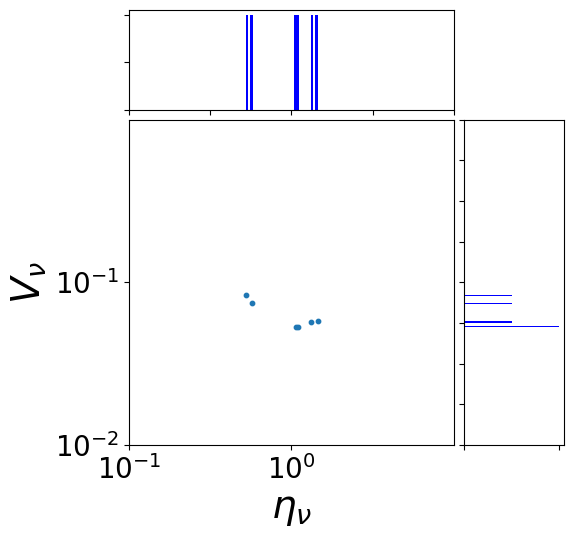

In [117]:
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In the simplest case, we now define variable sources as those that are significantly deviant from the population. i.e. we assume that the majority of sources in the radio sky are not variable. From experience, this is a pretty reasonable assumption.

We fit the &eta; and V distributions with a Gaussian curve. Then we can specify the number of &sigma; deviant we want to use as the threshold [(see Rowlinson et al. 2019 for more info)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract). Typically, 2&sigma; gives a reasonable result.

In [118]:
sigmaThresh = 1.5

In [119]:
from scipy.stats import norm

def SigmaFit(data):
    median = np.median(data)
    std_median = np.sqrt(np.mean([(i-median)**2. for i in data]))
    tmp_data = [a for a in data if a < 3.*std_median+median and a > median - 3.*std_median]
    param1 = norm.fit(tmp_data)
    param2 = norm.fit(data)
    return param1, param2

In [120]:
paramx, paramx2 = SigmaFit(np.log10(plotdata['eta']))
paramy, paramy2 = SigmaFit(np.log10(plotdata['V']))

print('Gaussian Fit eta: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print('Gaussian Fit V: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')

sigcutx = paramx[1]*sigmaThresh+paramx[0]
sigcuty = paramy[1]*sigmaThresh+paramy[0]

print('eta threshold = '+str(round(10.**sigcutx,2)))
print('V threshold = '+str(round(10.**sigcuty,2)))

Gaussian Fit eta: 0.93(+0.45 -0.31)
Gaussian Fit V: 0.06(+0.01 -0.01)
eta threshold = 1.69
V threshold = 0.08


We can now use these thresholds to identify which sources are variable and illustrate it in the plot.

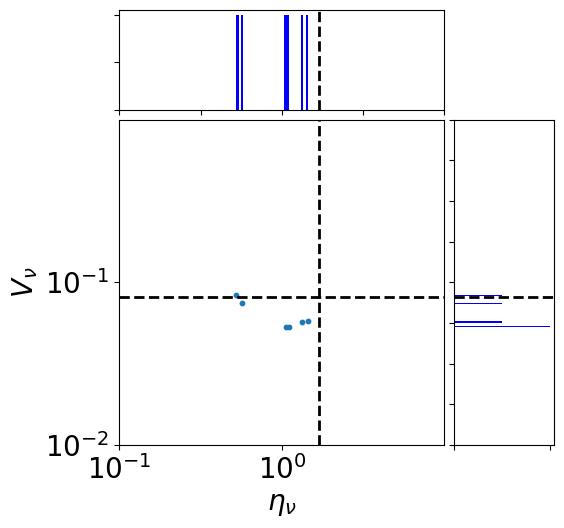

In [121]:

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=20)
plt.ylabel(r'$V_{\nu}$', fontsize=20)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

#axHistx.hist(x, bins=make_bins(x), histtype='stepfilled', color='b')
#axHisty.hist(y, bins=make_bins(y), histtype='stepfilled', orientation='horizontal', color='b')
axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In [122]:
variables = plotdata.loc[(plotdata['eta']>=10.**sigcutx) & (plotdata['V']>=10.**sigcuty)]
variables

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err,nearestBrtSrc


Obviously, the next step is to plot the light curve to confirm the variability visually. Usually we also want to visually inspect to check for artefacts so we will also load the image. Automating this step is underway for some types of artefacts - such as sidelobes of bright sources.

Assuming the images are still available, we can plot the source and its surroundings. To do this, we need to pull the full light curve for the sources out of the database and we need to access three new tables.

In [123]:
def extract_data(fits_file_path, ra, dec, size):    
    hdu = fits.open(fits_file_path)[0]
    data1 = hdu.data
    wmap = WCS(hdu.header, naxis=2)
    data1 = data1[0][0]
    return data1, wmap


def fix_axes_limits_ax1(ax1, RA_coord, DEC_coord, wmap,pix_lim):
    """Define a window of 2*pix_lim around the center coordinate in LoTSS."""
    px, py = wmap.wcs_world2pix(RA_coord, DEC_coord, 1)
    ax1.set_xlim(px-pix_lim, px+pix_lim)
    ax1.set_ylim(py-pix_lim, py+pix_lim)

    RA_min, DEC_min = wmap.wcs_pix2world(px-pix_lim, py-pix_lim, 1)
    RA_max, DEC_max = wmap.wcs_pix2world(px+pix_lim, py+pix_lim, 1)

    return px, py, RA_min, DEC_min, RA_max, DEC_max



In [124]:
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Ellipse

size = 100
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type, flxVals[x].Extractedsource.reduced_chisq] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type','rchisq'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)


    
    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()

    print(row.ra,row.dec)
    print(max(lightcurve.rchisq))
    for index2, row2 in lightcurve.iterrows():
        print(row2.Image)

variables['maxImg']=maxImgs


Once you've confirmed the transient candidate is not an artefact, it is useful to determine if there is an associated known source at the location. To do this, we typically query [Simbad](https://simbad.u-strasbg.fr/simbad/) and this can be done automatically within Python.

In [125]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord

searchRadius = 30. # in arcsec
searchRadius = (searchRadius/3600.)*u.deg

for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')
    

### Variability Searches - version 2

We have noticed that the variability parameters we use show a correlation with the maximum flux density of the source. We show this correlation here:

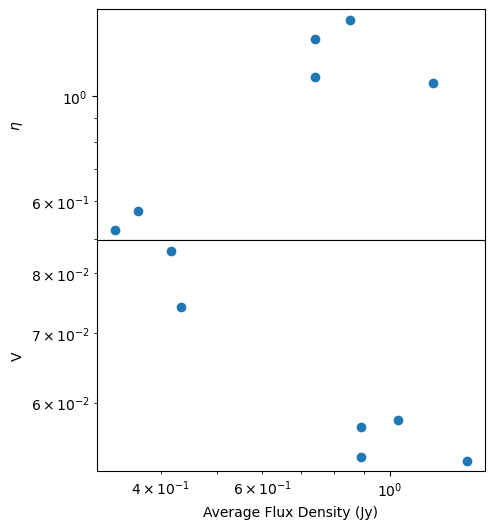

In [126]:
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.avgFlx,plotdata.eta)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$\eta$')
axs[1].scatter(plotdata.maxFlx,plotdata.V)
axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_ylabel('V')
axs[1].set_xlabel('Average Flux Density (Jy)')
for ax in axs:
    ax.label_outer()

Recent work by [Valdata et al. (in prep)]() takes into account this correlation. It fits the distribution with a linear function and then determines the distances of each data point from the correlation. As we only care about variable sources, we only select the sources that lie above the correlation. We convert to using the log10 values of the variability parameters and flux densities to simplify the code. In the following, we show a simplified version of the code - please refer to the [GitHub repository](https://github.com/ruggerovaldata/Separating-Candidate-Transients/tree/main) for the main code.

In [127]:
plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
plotdata['logFlux'] = plotdata.apply(lambda row: np.log10(row.maxFlx), axis=1)

/tmp/ipykernel_102401/1269240526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
/tmp/ipykernel_102401/1269240526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
/tmp/ipykernel_102401/1269240526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

We import the scripts used by Valdata et al. (in prep).

In [128]:
import myplotting as myplt
import functions as func

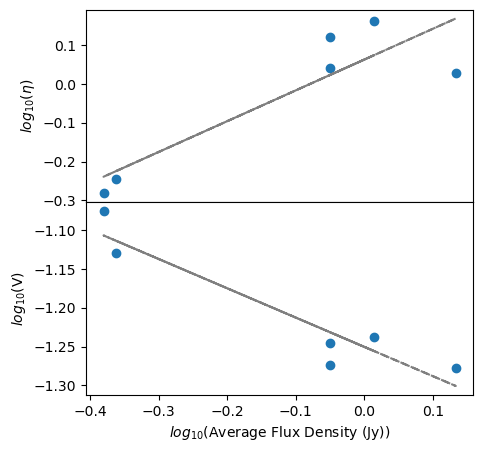

In [129]:
import scipy.optimize as spopt
import scipy.stats as spstat

freq = plotdata.freq.unique()
#Finding the line that best represents the two parameters of the data
best_params_eta, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logEta)
best_params_V, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logV)

m_eta, q_eta = best_params_eta[0],best_params_eta[1]
m_V, q_V = best_params_V[0],best_params_V[1]
y_eta = func.LinearFit(plotdata.logFlux,m_eta,q_eta)
y_V = func.LinearFit(plotdata.logFlux,m_V,q_V)

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.logFlux,plotdata.logEta)
axs[0].set_ylabel(r'$log_{10}$($\eta$)')
axs[0].plot(plotdata.logFlux,y_eta,label='Best fit',color='gray', ls='--')
axs[1].scatter(plotdata.logFlux,plotdata.logV)
axs[1].set_ylabel(r'$log_{10}$(V)')
axs[1].set_xlabel(r'$log_{10}$(Average Flux Density (Jy))')
axs[1].plot(plotdata.logFlux,y_V,label='Best fit',color='gray',ls='--')
for ax in axs:
    ax.label_outer()


Now we extract only the data points that lie above this line.

In [130]:
#Calculating the paramater distance from the line that has been found earlier
plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)

dataBest = plotdata.loc[(plotdata['distsEta'] > 0) & (plotdata['distsV'] > 0)]

/tmp/ipykernel_102401/3910120889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
/tmp/ipykernel_102401/3910120889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)


Now plot the distances from the two lines and fit a multivariate normal distribution to the data. We can then use this fit to determine which sources are outliers to the distribution.

In [131]:
p = 0.99 #Inserting here the percentage with which the source should be classified as inlier

data_graph = np.vstack([dataBest.distsEta,dataBest.distsV])
data_graph = data_graph.T

mean_deta = np.mean(dataBest.distsEta)
mean_dV = np.mean(dataBest.distsV)
mu = [mean_deta,mean_dV]

cov_matrix = np.cov(dataBest.distsEta,dataBest.distsV)
likelihood = spstat.multivariate_normal.pdf(data_graph,[mean_deta,mean_dV],cov_matrix)

outliers_prob = func.Probability(data_graph,mu,cov_matrix) #Calculating the probability for every parameter of being associated to an "inlier" source

dataBest['probability'] = 100.-outliers_prob
temp = dataBest.sort_values('probability')
dataBest.to_csv('WholedatasetoutputBest.csv', index=False)

figure, axes = myplt.MyCorner(dataBest.distsEta,dataBest.distsV,dataBest.probability/100.,'CornerPlotBest') #Printing the corner plot both with the likelihood and without the likelihood

chi2 = spstat.chi2.ppf([p],2)[0]

# finding the outliers with probabilities >99% and with positive distances abovve the trend line
inliersBest = dataBest.loc[ (dataBest['probability'] <= p*100.) ]
outliersBest = dataBest.loc[ (dataBest['probability'] > p*100.) ]


/tmp/ipykernel_102401/452078645.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(dataBest.distsEta,dataBest.distsV)
/home/antoniar/miniconda3/envs/P_test/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/antoniar/miniconda3/envs/P_test/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

In [ ]:
# Plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,14))

ax1.scatter(outliersBest.logFlux,outliersBest.logEta,color='red',label='Outliers')
ax1.scatter(inliersBest.logFlux,inliersBest.logEta,color='blue',label='Inliers')
ax2.scatter(outliersBest.logFlux,outliersBest.logV,color='red',label='Outliers')
ax2.scatter(inliersBest.logFlux,inliersBest.logV,color='blue',label = 'Inliers')

ax1.set_ylabel(r'$log_{10}(\eta_{\nu}$)',fontsize=30)
ax2.legend(fontsize=15,markerscale=1.5)
ax1.legend(fontsize=15,markerscale=1.5)
ax2.set_ylabel(r'$log_{10}(V_{\nu}$)',fontsize=30)
ax2.set_xlabel(r'$log_{10}(Flux) (Jy)$',fontsize=30)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
plt.savefig('EtavsVscatterinoutBest')

figure,ax = myplt.OutInPlot(np.array([outliersBest.distsEta, outliersBest.distsV]).T,np.array([inliersBest.distsEta,inliersBest.distsV]).T,'OutIn_UnstableBest')
EtaVsVout, axveta = myplt.OutInPlot(np.array([outliersBest.logEta, outliersBest.logV]).T,np.array([inliersBest.logEta,inliersBest.logV]).T,'OutInEtavsVBest')
axveta.set_xlabel(r'$log_{10}(\eta_{\nu})$',fontsize=30)
axveta.set_ylabel(r'$log_{10}(V_{\nu})$',fontsize=30)


In [ ]:
# Outputting variable candidates
print('Number of outliers : ', len(outliersBest))

if len(outliersBest) == 0:
    print('No candidate variable sources found.')
else:
    print(outliersBest.runcat)

Now we can look at the light curves and images as with the previous variability searches.

In [ ]:
variables = outliersBest
#variables = pd.merge(variables,positions,how='inner', on='runcat')
variables

In [ ]:
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type,flxVals[x].Extractedsource.reduced_chisq] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type','rchisq'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    print(max(lightcurve.rchisq))

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)

    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
    
variables['maxImg']=maxImgs

In [ ]:
for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')

### Single epoch flares

The variability parameters used in the above analysis are good at identifying variability over multiple epochs, however they are bad at identifying sources that have a single epoch flare. [Valdata et al. (in prep)]() show that implementing a simple moving average search can successfully find these sources. n.b. this method is currently slow for large datasets and will require further optimisation.

In [ ]:
y = session.query(Extractedsource,Assocxtrsource).select_from(join(Extractedsource,Assocxtrsource)).filter(Assocxtrsource.runcat_id.in_(plotdata.runcat)).all()
data = [[y[i].Extractedsource.id, y[i].Assocxtrsource.runcat_id, y[i].Extractedsource.image.taustart_ts, y[i].Extractedsource.f_int, y[i].Extractedsource.f_int_err] for i in range(len(y))]
data=pd.DataFrame(data=data, columns =['srcID','runcat','time','flux','fluxErr'])
data=data.sort_values(['runcat','time'])

In [ ]:
window_size = 12  # the number of data points used for the moving average calculation
cutoff_val = 3 # the number of sigma used to determine the optimal cut on the 
minDatapoints = 12 # the minimum number of data points needed in the source light curve to be included in the analysis
sigma =3. # the number of sigma the deviation has to be above the flux uncertainties

In [ ]:
finalData = pd.DataFrame(columns = ["srcID","runcat","time","flux","fluxErr","dpts","MAvg","deviation","candidate"])
runcatIDs = data.runcat.unique()

for runcat in runcatIDs:
    lc = data.loc[data['runcat'] == runcat]
    lc = lc.reset_index()
    lc["dpts"] = lc.index+1
    lc['MAvg'] = lc['flux'].rolling(window=window_size, min_periods=1).mean()
    std = lc.flux.std()
    lc['deviation'] = (lc['flux'] - lc['MAvg']) / std
    lc['candidate'] = np.where(np.abs(lc['flux'] - lc['MAvg']) > (sigma * lc['fluxErr']), 1, 0)
    lc = lc.fillna(0)
    lc = lc.drop('index',axis=1)
    finalData = finalData._append(lc, ignore_index=True)

# remove all rows with a zero deviation
finalData = finalData.loc[finalData['deviation'] != 0]

In [ ]:
# Find transients that have deviation values that lie above threshold value
all_deviations = finalData.deviation
print(len(all_deviations))
params_med = np.median(all_deviations), np.sqrt(np.mean([(i-np.median(all_deviations))**2. for i in all_deviations]))
threshold = cutoff_val * params_med[1]

In [ ]:
def plothist(x, threshold, filename):
# Create a histogram of the data t
    plt.hist(x,bins=50,histtype='stepfilled')
    plt.axvline(x=threshold, linewidth=2, color='k',linestyle='--')
    plt.xlabel('Deviation')
    plt.ylabel('Number of sources')
    plt.savefig(filename)
    plt.show()
    return
    
plothist(all_deviations, threshold, 'LOFAR_deviation_hist.png')

In [ ]:
candidates = finalData.loc[(finalData['deviation'] > threshold) & (finalData['dpts'] >= minDatapoints) & (finalData['candidate'] == 1)]

if len(candidates) == 0:
    print('No candidate variable sources found.')
else:
    srcs=list(candidates.runcat)
    print(srcs)

In [ ]:
for index, row in plotdata.iterrows():
    sourceID = row.runcat
    if sourceID in srcs:
        flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
        lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
        lightcurve = pd.merge(lightcurve, images, on="Image")

        print('Runcat = '+str(sourceID))
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(121)
        ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
        for index2, row2 in lightcurve.iterrows():
            if row2.type==0:
                ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
            if row2.type==1:
                ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
        ax1.axhline(y=0.0, color='k', linestyle=':')
        ax1.tick_params(axis='x', labelrotation=90)
        ax1.set_ylabel('Flux density (Jy)')
        ax1.set_xlabel('Time')

        maxFlux = np.max(lightcurve.Flux)
        maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]

        extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
        ax2 = fig.add_subplot(122, projection=wcs)
        fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
        ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
        ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
        ax2.coords[0].set_format_unit(u.deg)
        ax2.coords[1].set_format_unit(u.deg)
 
        ax2.set_xlabel('Right Ascension (deg)')
        ax2.set_ylabel('Declination (deg)')
        plt.show()

        # Find any associated sources in Simbad
        print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
        result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
        srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
        if result_table:
            results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
            results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
            print(results)
        else:
            print('no matches')

### Transient searches

The previous methods focused on sources that were identified in the first image in a dataset and are looking for significant variability. Another key science case is transient sources, namely sources that were not detected in the first image and were found in subsequent images. The TraP has a specific table for newly identified sources, [newsource](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource). 

The following code is based upon the *filter_new_sources.py* example code in the [TraP_tools](https://github.com/transientskp/TraP_tools) repository.

In [132]:
from tkp.db.model import Newsource
NewSrcs = session.query(Newsource, Runningcatalog).select_from(join(Newsource, Runningcatalog)).filter(Runningcatalog.dataset_id ==dataset_id).all()

In [133]:
NewSrcData=[[NewSrcs[i].Runningcatalog.id,NewSrcs[i].Newsource.trigger_xtrsrc.ra,NewSrcs[i].Newsource.trigger_xtrsrc.decl,NewSrcs[i].Newsource.trigger_xtrsrc.id,
             NewSrcs[i].Newsource.trigger_xtrsrc.image.taustart_ts,NewSrcs[i].Newsource.trigger_xtrsrc.det_sigma,NewSrcs[i].Newsource.newsource_type,
             SkyCoord(ra=(NewSrcs[i].Runningcatalog.wm_ra*u.degree),dec=(NewSrcs[i].Runningcatalog.wm_decl*u.degree)),NewSrcs[i].Newsource.trigger_xtrsrc.image.url] for i in range(len(NewSrcs))]
NewSrcDataFrame = pd.DataFrame(data=NewSrcData, columns=['RuncatID','ra','dec','xtrsrc','TimeDetect','detSigma','type','SkyCoord','detectImage'])
NewSrcDataFrame = NewSrcDataFrame.sort_values(by=['detSigma'])
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage
98,44632,-117.592256,55.448396,336562,2018-11-25 10:18:04.000,6.001372,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.3...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
36,44417,-116.866565,54.301135,312540,2018-11-25 08:29:07.000,6.001522,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.1...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
25,44361,-114.802650,54.847977,308462,2018-11-25 08:04:00.900,6.001780,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (245.1...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
211,44957,-115.872234,53.991527,316443,2018-11-25 08:52:04.900,6.003077,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.1...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
212,44956,-115.872234,53.991527,316443,2018-11-25 08:52:04.900,6.003077,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.1...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
...,...,...,...,...,...,...,...,...,...
230,44986,-117.230659,54.672493,349975,2018-11-25 10:57:19.300,7.771064,1,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.7...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
266,45088,-118.452767,53.798231,422051,2018-11-25 13:48:13.500,8.591022,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (241.5...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
264,45085,-118.452767,53.798231,422051,2018-11-25 13:48:13.500,8.591022,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (241.5...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...
265,45087,-118.452767,53.798231,422051,2018-11-25 13:48:13.500,8.591022,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (241.5...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...


**xtrsrc** is the id of the extracted source that was the first detection of this source

**TimeDetect** is the detection time of the new source

**detSigma** is the significance of the new source detection

**type** Refers to how certain we are that the newly discovered source is really “physically new”, i.e. transient. Since we do not store fine-grained noise-maps in the database, we must be fairly conservative in our labelling here. Type 0 sources may be a steady source located in a high-RMS region, newly detected due to noise fluctuations, or may be a real transient in a low-RMS region. Type 1 sources are bright enough that we can be fairly certain they are really new - they are significantly brighter than the rms_max in the previous image with best detection limits. (definition from the TraP documentation for the [newsource table](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource).)

In [134]:
print("Number of new sources (before Filtering): "+str(len(NewSrcDataFrame)))

Number of new sources (before Filtering): 292


#### Filter 0: Remove any sources that fit poorly to the restoring beam
i.e. extended sources and sources that are not point like

In [135]:
extendedSrcs=[]
for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.xtrsrc
    extractedSrcs = session.query(Extractedsource).filter(Extractedsource.id == sourceID).all()
    fit_value = extractedSrcs[0].reduced_chisq 
    if fit_value>100:
        extendedSrcs.append(row.RuncatID)
print(extendedSrcs)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(extendedSrcs)]

[44632, 44417, 44361, 44957, 44956, 45011, 44511, 44979, 45009, 44510, 45047, 44980, 45046, 44439, 45056, 45163, 45057, 45020, 44995, 44993, 44997, 45164, 44958, 45170, 45051, 45052, 45169, 45160, 45144, 45123, 44928, 44906, 44769, 44862, 44983, 44883, 44982, 44663, 44884, 44880, 44976, 44971, 44792, 44926, 44905, 44970, 44733, 44752, 44911, 44830, 44590, 44589, 45119, 44891, 44846, 44609, 44320, 44428, 44973, 44972, 44614, 44757, 44826, 44917, 44857, 45001, 45003, 44717, 45004, 44856, 44724, 44807, 44899, 44936, 44848, 44810, 44897, 44960, 44789, 44959, 44823, 44935, 44633, 44859, 44910, 44423, 44951, 44945, 44952, 44949, 44908, 44781, 44776, 44778, 44944, 44953, 44506, 44985, 44548, 45006, 45005, 44577, 44579, 44587, 44588, 44543, 44600, 44652, 44606, 44877, 44876, 44625, 44916, 44628, 44636, 44902, 44504, 44531, 44894, 45166, 45165, 44730, 45016, 44731, 44362, 44670, 44617, 44466, 44946, 44424, 45058, 45059, 44904, 44896, 44289, 45193, 44764, 44763, 44664, 44425, 44547, 44311, 44312

#### Filter 1: Remove any sources that are caused by source association errors and were detected in the first image

First obtain a list of all the sources detected in the first image and then conduct a simple source association between them. We define a source association radius as the typical maximum restoring beam size multiplied by the number of beam widths that we would consider two sources to be associated within. The beam widths can be the same as used in the TraP job_param.cfg file (see beamwidths_limit in example above).

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [136]:
# obtain all the sources in the first image from the dataset
images= session.query(Image).select_from(Image).filter(Image.dataset_id == dataset_id).all()
Imgs = [images[i].id for i in range(len(images))]
Img1 = min(Imgs)
ExtractedSrcs = session.query(Extractedsource, Assocxtrsource).select_from(join(Extractedsource, Assocxtrsource)).filter(Extractedsource.image_id == Img1).all()
Img1Srcs = [ExtractedSrcs[i].Assocxtrsource.runcat.id for i in range(len(ExtractedSrcs))]

# find the restoring beam major axis from the first image - n.b. we assume all images have roughly the same BMaj in this analysis
BMaj = images[0].rb_smaj

In [137]:
# define the number of beam widths you want to use for association
beamwidths = 5.

# here we calculate the source association radius in degrees. 
# Instead of using the beam width, you could simply insert a value here
SrcAssocRadius = BMaj * beamwidths *u.degree
print('Source association radius = '+str(SrcAssocRadius))

Source association radius = 0.0793956507038175 deg


In [138]:
# get the positions of all the runcat sources found in the first image
runcats_tmp = session.query(Runningcatalog).filter(Runningcatalog.id.in_(Img1Srcs)).all()
positions = [[runcats_tmp[i].id,runcats_tmp[i].wm_ra,runcats_tmp[i].wm_decl,SkyCoord(ra=(runcats_tmp[i].wm_ra*u.degree),dec=(runcats_tmp[i].wm_decl*u.degree))] for i in range(len(runcats_tmp))]
positions = pd.DataFrame(positions, columns=['runcat','ra','dec','SkyCoord'])

In [139]:
# Now conduct a simple source association
newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
img1Pos = SkyCoord(ra=(positions.ra.values)*u.degree,dec=(positions.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestSrc > SrcAssocRadius]

/tmp/ipykernel_102401/4225000774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewSrcDataFrame['nearestSrc'] = d2d.deg


In [140]:
print("Number of new sources (after Filter 1): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 1): 29


#### Filter 2: Reject all sources that are too close to the source extraction radius

There is a known issue of false positive sources getting identified at the source extraction radius. We aim to address this in future versions of the source finder. For now, we reject any sources that are too close to the extraction radius by a given FilterRadius.

**CAVEAT:** this implementation assumes that all the images are of the same sky region. If you want to process multiple sky regions, you need to generalise this code.

In [141]:
FilterRadius = 0.1 # in degrees, 0.017~1'

In [142]:
from tkp.db.model import Skyregion

skyreg = session.query(Skyregion).select_from(Skyregion).filter(Skyregion.dataset_id == dataset_id).one() # open up the first sky region file
centre = SkyCoord(ra=(skyreg.centre_ra*u.degree),dec=(skyreg.centre_decl*u.degree)) # get the central co-ordinates of the sky region
xtrRadius = skyreg.xtr_radius # get the extraction radius used in TraP


In [143]:
filteredRuncats=[]
for index, row in NewSrcDataFrame.iterrows():
    sep = row.SkyCoord.separation(centre)
    if sep.degree < xtrRadius - FilterRadius:
        filteredRuncats.append(row.RuncatID)

NewSrcDataFrame = NewSrcDataFrame[NewSrcDataFrame['RuncatID'].isin(filteredRuncats)]

In [144]:
print("Number of new sources (after Filter 2): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 2): 26


#### Filter 3: Is the source in the NVSS Catalogue?

This is an example to show how to filter the sources against a catalogue. The goal of the transient search is to find new, undetected sources, therefore they should not be associated with a catalogue source.

In [145]:
from astroquery.xmatch import XMatch
from astropy.table import Table

MaxSep = BMaj * beamwidths * 3600. # in arcsec

input_table = Table.from_pandas(NewSrcDataFrame)

table = XMatch.query(cat1=input_table,
                     cat2='vizier:VIII/65/nvss',
                     max_distance=MaxSep * u.arcsec, colRA1='ra',
                     colDec1='dec')

# The LoTSS DR1 sky catalogue is 'vizier:J/A+A/622/A1'

table = table.to_pandas()

Could not import regions, which is required for some of the functionalities of this module.


ValueError: max_distance argument must not be greater than 180

In [146]:
assoc_runcats = list(table.RuncatID)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(assoc_runcats)]

AttributeError: 'function' object has no attribute 'RuncatID'

In [148]:
print("Number of new sources (after Filter 3): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 3): 26


#### Filter 4: Is the source in the deep image?

Some catalogues may not be sufficiently deep or at a sufficiently good observing frequency for all the associations with constant sources to be found. Therefore, it is often good to compare your newly detected sources to a deep image of the field made using the same instrument. Here, we use a deep image of the field but you could also simply use a catalogue.

We first run the PySE source finder on the image. PySE is the standalone version of the sourcefinder from TraP. I recommend using the same sourcefinder parameters as you specified in the TraP job_params.cfg file.

**CAVEAT:** Bright single epoch transient sources may still be detected in the deep image. One check for this is to see if the source is significantly brighter than the flux density measured in the deep image.

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [149]:
import os

DeepImg = 'GRB201006A_deep-image-pb.fits'

os.system('pyse.py --detection 8 --analysis 3 --force-beam --csv '+DeepImg)

/home/antoniar/miniconda3/envs/P_test/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing GRB201006A_deep-image-pb.fits (file 1 of 1).


Traceback (most recent call last):
  File "/home/antoniar/miniconda3/envs/P_test/bin/pyse.py", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/scratch/antoniar/TraP6.0/tkp/tkp/bin/pyse.py", line 361, in <module>
    print(run_sourcefinder(files, options), end=' ')
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/antoniar/TraP6.0/tkp/tkp/bin/pyse.py", line 298, in run_sourcefinder
    ff = open_accessor(filename, beam=beam, plane=0)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/antoniar/TraP6.0/tkp/tkp/accessors/__init__.py", line 69, in open
    raise OSError("%s does not exist!" % path)
OSError: GRB201006A_deep-image-pb.fits does not exist!


256

In [150]:
deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")

newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
deepSrcsPos = SkyCoord(ra=(deepSrcs.ra.values)*u.degree,dec=(deepSrcs.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(deepSrcsPos)
NewSrcDataFrame['nearestDeepSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestDeepSrc > SrcAssocRadius]

/tmp/ipykernel_102401/2842393031.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")


In [151]:
print("Number of new sources (after Filter 4): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 4): 26


#### Filter 5: Removing side lobes

To see a full analysis of how to handle sidelobes, refer to [de Ruiter et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.2412D/abstract) and [de Ruiter et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv231107394D/abstract).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

**CAVEAT:** This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [152]:
FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# Reminder: the positions dataframe contains all the runcat sources in the first image and Img1Srcs is a list of all the runcat ids
# we need the average flux density from the runningcatalog_flux table
from tkp.db.model import RunningcatalogFlux

runcat_fluxes = session.query(RunningcatalogFlux).filter(RunningcatalogFlux.id.in_(Img1Srcs)).all()
runcat_fluxes = [[runcat_fluxes[i].id,runcat_fluxes[i].avg_f_int] for i in range(len(runcat_fluxes))]
runcat_fluxes = pd.DataFrame(data=runcat_fluxes, columns=['RuncatID','AvgFlx'])

# now identify the brightest sources
runcat_bright = runcat_fluxes.loc[runcat_fluxes.AvgFlx > BrightSrcFlx]
brightSrcs = runcat_bright['RuncatID'].tolist()

# Now conduct a simple source association between these sources and the transient candidates



newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestBrtSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestBrtSrc > FilterRadius/60. ]


In [153]:
print("Number of new sources (after Filter 5): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 5): 26


#### Other possible filters

These are 5 key filters that you can use on your transient source candidates. There are other options which can be applied to your data, such as:
- using 2 or more observing frequency bands and requiring that the source is present in all of them (good for removing e.g. noise fluctuations or narrow-band RFI sources)
- worth investigating - extended sources are not going to be transient sources, so you could possibly use the source finder fit quality (see e.g. the parameters chisq, reduced_chisq from the extracted source table).

In [154]:
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage,nearestSrc,nearestDeepSrc,nearestBrtSrc
95,44626,-115.929481,54.288959,334403,2018-11-25 10:10:03.400,6.004215,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.0...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.323320,60.129937,0.323320
56,44514,-117.997957,56.103639,322986,2018-11-25 09:24:23.600,6.008913,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.0...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.138850,58.331894,0.138850
147,44784,-115.435853,55.896614,356658,2018-11-25 11:12:00.500,6.023182,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.5...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.263305,58.515540,0.263305
96,44627,-117.799674,54.092165,335112,2018-11-25 10:12:27.600,6.062154,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.2...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.191599,60.343323,0.191599
133,44759,-117.163701,55.477714,308051,2018-11-25 08:01:20.600,6.062769,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.8...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.153580,58.954523,0.153580
137,44762,-117.163701,55.477714,308051,2018-11-25 08:01:20.600,6.062769,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.8...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.153580,58.954523,0.153580
0,44871,-117.163701,55.477714,308051,2018-11-25 08:01:20.600,6.062769,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.8...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.153580,58.954523,0.153580
4,44872,-117.163701,55.477714,308051,2018-11-25 08:01:20.600,6.062769,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.8...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.153580,58.954523,0.153580
3,44873,-117.163701,55.477714,308051,2018-11-25 08:01:20.600,6.062769,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.8...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.153580,58.954523,0.153580
156,44806,-118.066142,54.843279,358334,2018-11-25 11:15:12.800,6.066321,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (241.9...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.256273,59.592226,0.256273


#### Bonus filter: remove planes and satellites

Sometimes planes and satellites can pass through your field of view giving a moving point source. This leads to multiple false positive new source detections that are sequentially following each other. See this image for example.

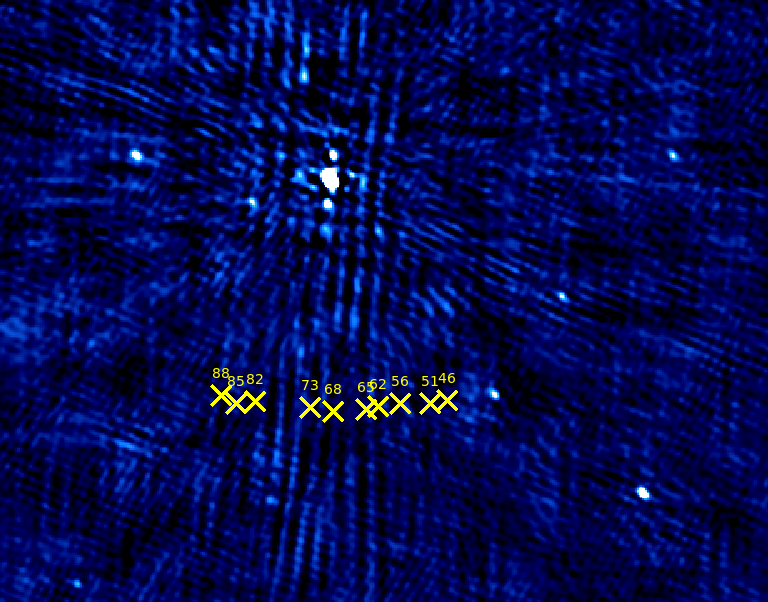

It is possible to filter these out of your false positives using a method developed for the AARTFAAC whole sky imager and outlined in the filtering stategies in [Kuiack et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.2966K/abstract). 
> "We found that excluding new source detections that occur within a space–time distance of 2.5° angular separation and 500 s was adequate to reject moving sources; these parameters were tuned using a sample data set which contained a number of transiting unidentified flying objects."

Sadly, with the advent of satellite constellations that are emitting or reflecting radiation (for LOFAR and Starlink see e.g. [Di Vruno et al.](https://ui.adsabs.harvard.edu/abs/2023A%26A...676A..75D/abstract)) and filters like this will likely become more important.

The following code is based upon the filtering strategy developed by Kuiack and his code is available here on [GitHub](https://github.com/mkuiack/scratchpad/blob/2664e6812f16003e4947839d7de8a9d474e8cbc4/scripts/StreamingHarvest.py#L532-L538)

In [155]:
# Loop through all the remaining candidates and remove sources associated in space (<2.5 deg) and time (<500 sec)
rejected_runcats=[]

for index, row in NewSrcDataFrame.iterrows():
    c1 = row.SkyCoord
    for index2, row2 in NewSrcDataFrame.iterrows():
        if index2 > index:
            c2 = row2.SkyCoord
            if (c1.separation(c2).deg < 2.5) and ((row2.TimeDetect-row.TimeDetect).total_seconds() < 600):
                rejected_runcats.append(row.RuncatID)
                rejected_runcats.append(row2.RuncatID)

rejected_runcats = np.unique(rejected_runcats)
rejected_runcats



array([44458, 44514, 44525, 44528, 44580, 44626, 44627, 44635, 44657,
       44687, 44712, 44759, 44762, 44784, 44806, 44821, 44822, 44871,
       44872, 44873, 44892, 44893])

In [156]:
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(rejected_runcats)]
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage,nearestSrc,nearestDeepSrc,nearestBrtSrc
257,45055,-117.760509,55.942582,409241,2018-11-25 13:09:46.300,6.121640,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.2...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.165498,58.492877,0.165498
263,45084,-115.597159,53.987848,423016,2018-11-25 13:50:53.800,6.138964,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.4...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.138978,60.426116,0.138978
273,45124,-115.546191,54.006921,433161,2018-11-25 14:20:16.200,6.168010,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (244.4...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.171708,60.406258,0.171708
177,44847,-117.875181,54.594893,363507,2018-11-25 11:27:13.800,6.179400,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (242.1...",/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS...,0.377066,59.840635,0.377066


#### Visual Inspection

The goal is to filter as many noise artefacts as possible before reaching this stage. But, visual inspection is often required before confirming a source is transient. Here we plot the light curve and the detection image, in the same way as we did for the variable source candidates.

Runcat = 45055
RA: -117.76050937003646 Dec: 55.942581730895505
Image = /archive/TraP_test_data/ELAIS-N1/L686976/ELIAS_L686976-t1231-image-pb.fits


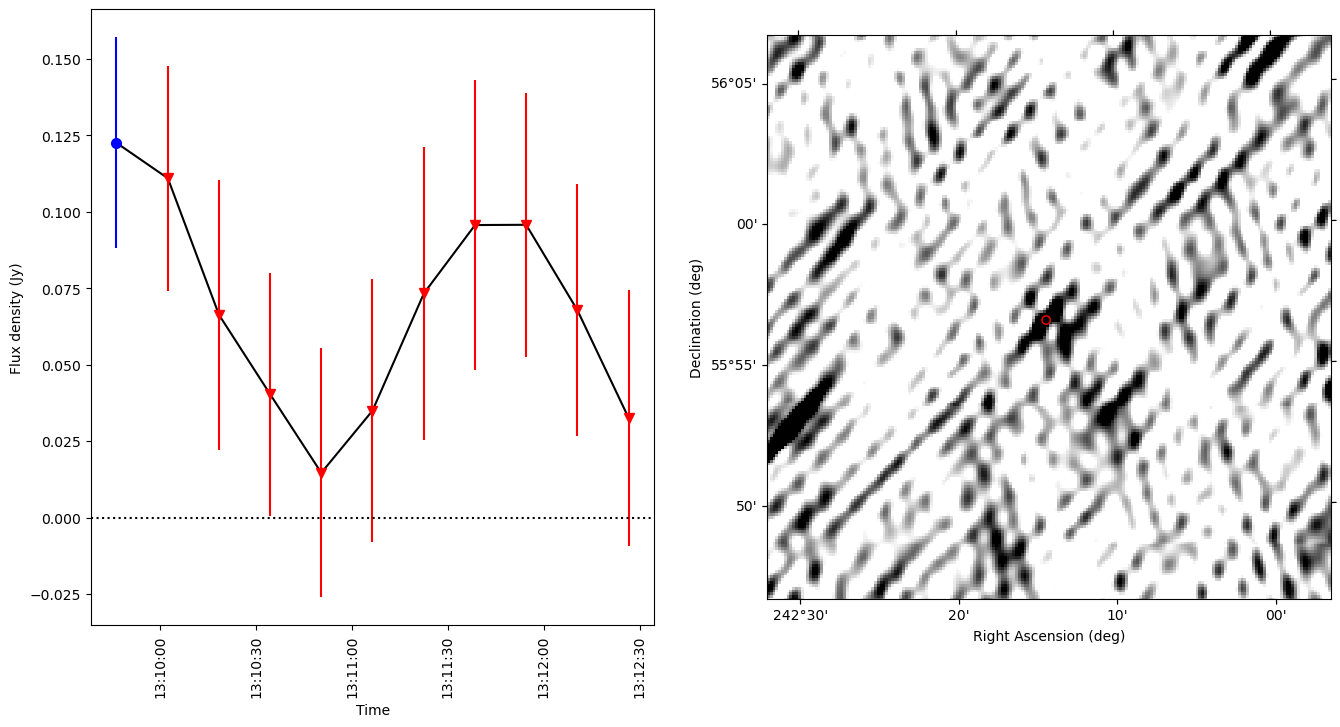

Runcat = 45084
RA: -115.59715866267473 Dec: 53.98784778289214
Image = /archive/TraP_test_data/ELAIS-N1/L686976/ELIAS_L686976-t1385-image-pb.fits


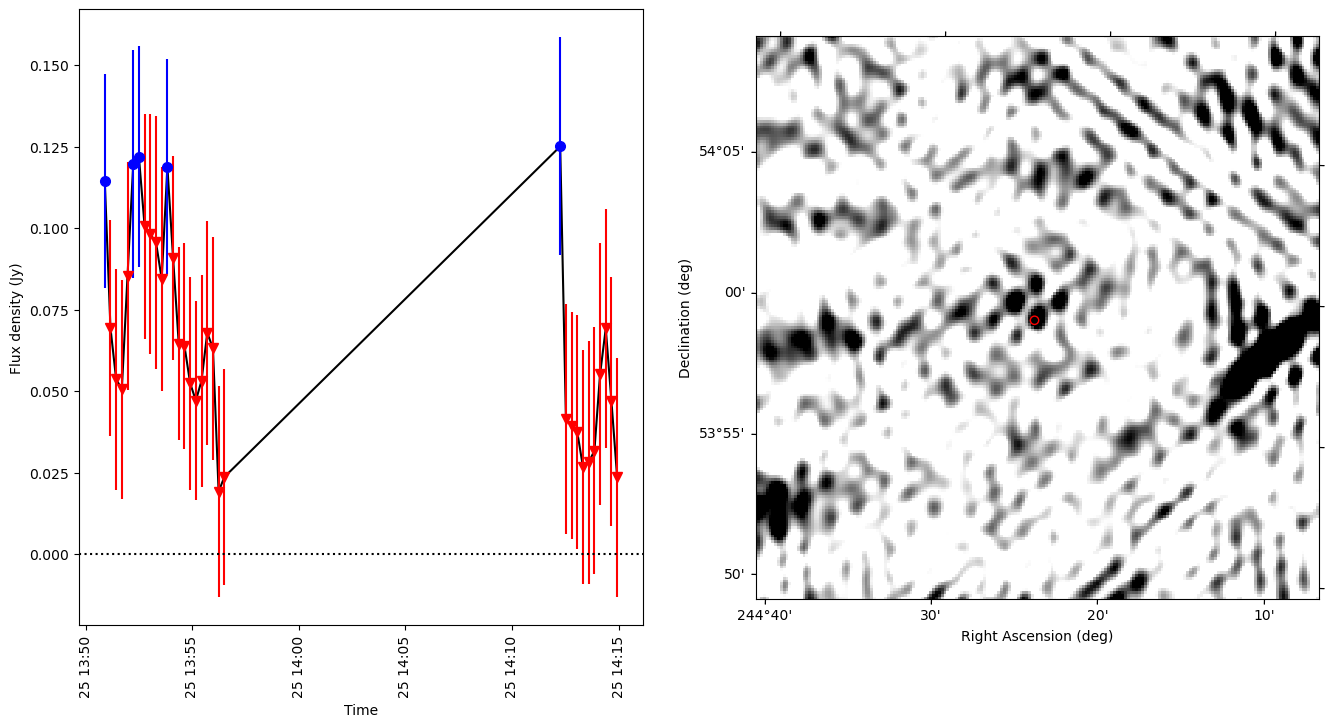

Runcat = 45124
RA: -115.54619132993945 Dec: 54.00692082711944
Image = /archive/TraP_test_data/ELAIS-N1/L686976/ELIAS_L686976-t1495-image-pb.fits


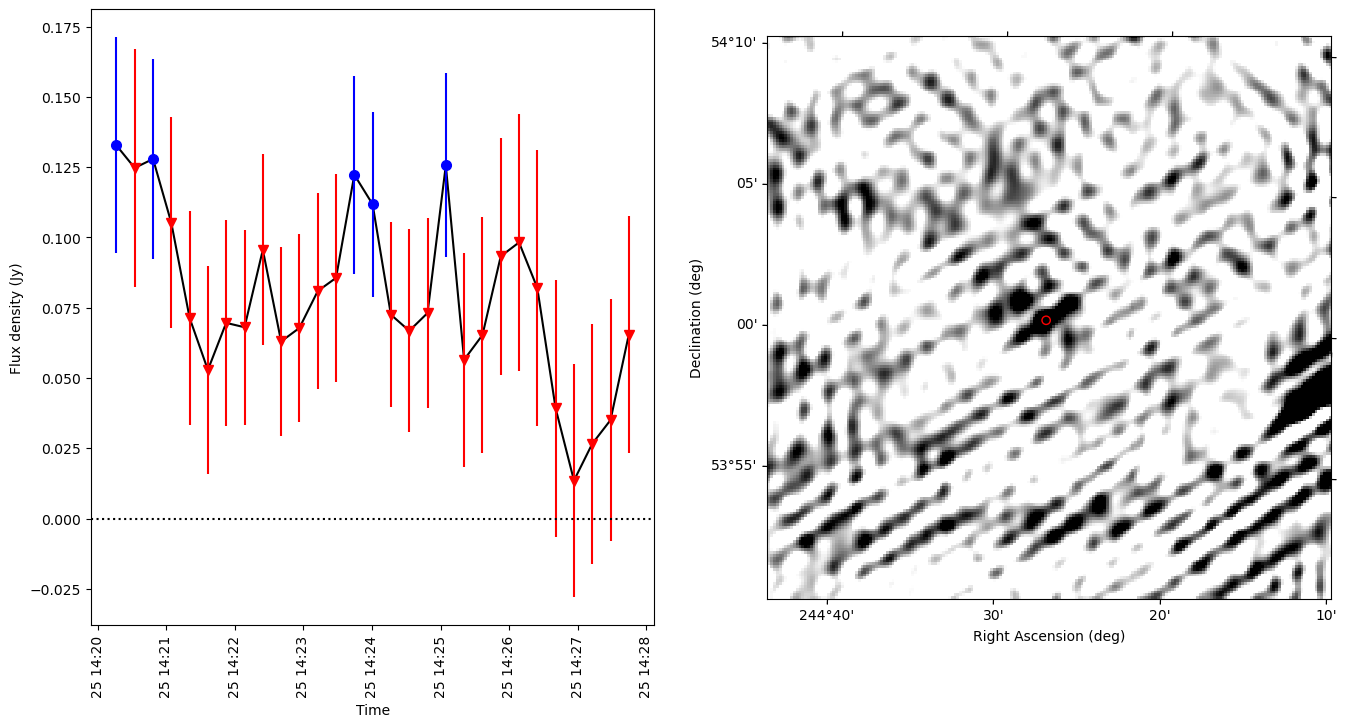

Runcat = 44847
RA: -117.87518130942753 Dec: 54.59489322908854
Image = /archive/TraP_test_data/ELAIS-N1/L686976/ELIAS_L686976-t0847-image-pb.fits


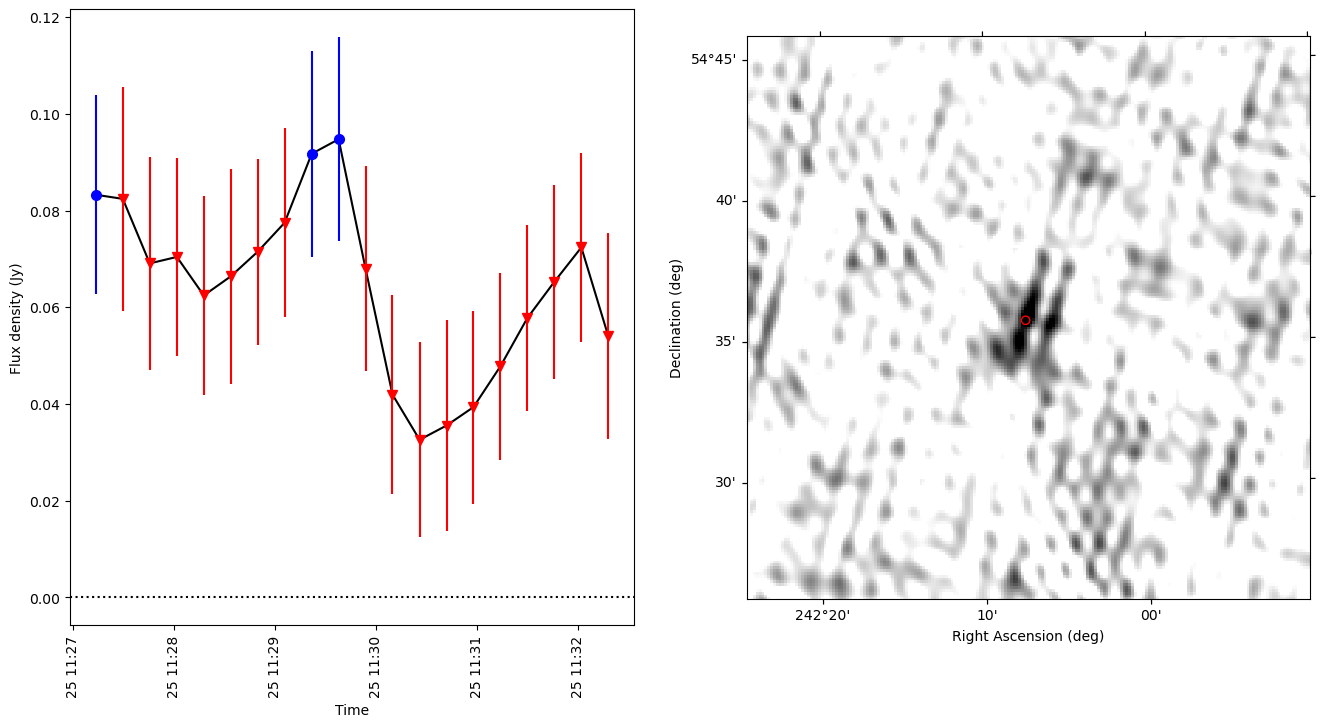

In [157]:
images2 = session.query(Image).filter(Image.dataset_id == dataset_id).all()
images2 = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.RuncatID
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images2, on="Image")

    print('Runcat = '+str(sourceID))
    print('RA: '+str(row.ra)+' Dec: '+str(row.dec))
    print('Image = '+row.detectImage)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux=0.05
    
    extractedData, wcs = extract_data(row.detectImage,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
